# perfect recovery with least absolute deviation in robust regression

## Least absolute deviation

Least Absolute Deviation refers to the M-estimator $$
\hat\beta = 
\operatorname{argmin}_{b\in \mathbb R^p} \sum_{i=1}^n |y_i - x_i^Tb|,
$$ that is, minimizing the absolute values of the residuals. The
minimization problem can be reduced to a linear program. In python this
estimator can be computed as follows.

In [1]:
import numpy as np
from sklearn.linear_model import QuantileRegressor

QuantileRegressor(quantile=0.5, alpha=0.0, fit_intercept=False, solver='highs')

QuantileRegressor(alpha=0.0, fit_intercept=False) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.   QuantileRegressor ? Documentation for QuantileRegressor i Not fitted QuantileRegressor(alpha=0.0, fit_intercept=False)

## Experiment

In a simple regression model with $y_i = x_i^T\beta^* + \varepsilon_i$
for some ground truth $\beta^*\in\mathbb R^p$, normal feature vectors
$x_i\sim N(0_p, I_p)$ and noise $\varepsilon_i$ independent of $x_i$, we
look at the probablity of perfect recovery, $$
P(\hat b = \beta^*),
$$ as a function of $P(\varepsilon_i=0)$ (number of noise variables
being zero/non-zero) and of the dimension/sample size ratio $p/n$.

In [2]:
def compute(n, p, o, seed=None):
    regr = QuantileRegressor(quantile=0.5, alpha=0.0, fit_intercept=False, solver='highs')
    rng = np.random.default_rng(seed=seed)
    X = rng.standard_normal(size=(n, p))
    beta_star = rng.standard_normal(size=(p, ))
    y = X @ beta_star + rng.standard_cauchy(size=(n, )) * np.hstack([np.ones(o), np.zeros(n-o)])
    regr.fit(X, y)
    return {'n': n, 'p': p, 'o': o, 'seed': seed,
            'perfect recovery': np.allclose(regr.coef_, beta_star)}

compute(100, 10, 30, seed=6)

{'n': 100, 'p': 10, 'o': 30, 'seed': 6, 'perfect recovery': True}

This experiment is repeated across values of $p$ (the dimension) and $o$
(number of nonzero values among $\varepsilon_1,...,\varepsilon_n)$. For
each value of $o\in[n]$, $p\in[n]$, the experiment is repeated 10 times.

In [3]:
n = 100
parameters = [dict(n=n, p=p, o=o,  seed=seed)
            for o in range(0, n+1)
            for p in range(1, n+1)
            for seed in range(10)
         ]
f"Will now launch {len(parameters)} parallel tasks"

'Will now launch 101000 parallel tasks'

In [4]:
from joblib import Parallel, delayed
# Heavy computation
data = Parallel(n_jobs=18, verbose=2)(delayed(compute)(**d)
                                      for d in parameters)

[Parallel(n_jobs=18)]: Using backend LokyBackend with 18 concurrent workers.
[Parallel(n_jobs=18)]: Done   5 tasks      | elapsed:    0.5s
[Parallel(n_jobs=18)]: Done 225 tasks      | elapsed:    0.7s
[Parallel(n_jobs=18)]: Done 4768 tasks      | elapsed:    3.0s
[Parallel(n_jobs=18)]: Done 13824 tasks      | elapsed:    7.9s
[Parallel(n_jobs=18)]: Done 25504 tasks      | elapsed:   14.5s
[Parallel(n_jobs=18)]: Done 39744 tasks      | elapsed:   24.0s
[Parallel(n_jobs=18)]: Done 56608 tasks      | elapsed:   37.0s
[Parallel(n_jobs=18)]: Done 76032 tasks      | elapsed:   52.0s
[Parallel(n_jobs=18)]: Done 98080 tasks      | elapsed:  1.1min
[Parallel(n_jobs=18)]: Done 101000 out of 101000 | elapsed:  1.2min finished

## Heatmap: empirical probabilities for perfect recovery

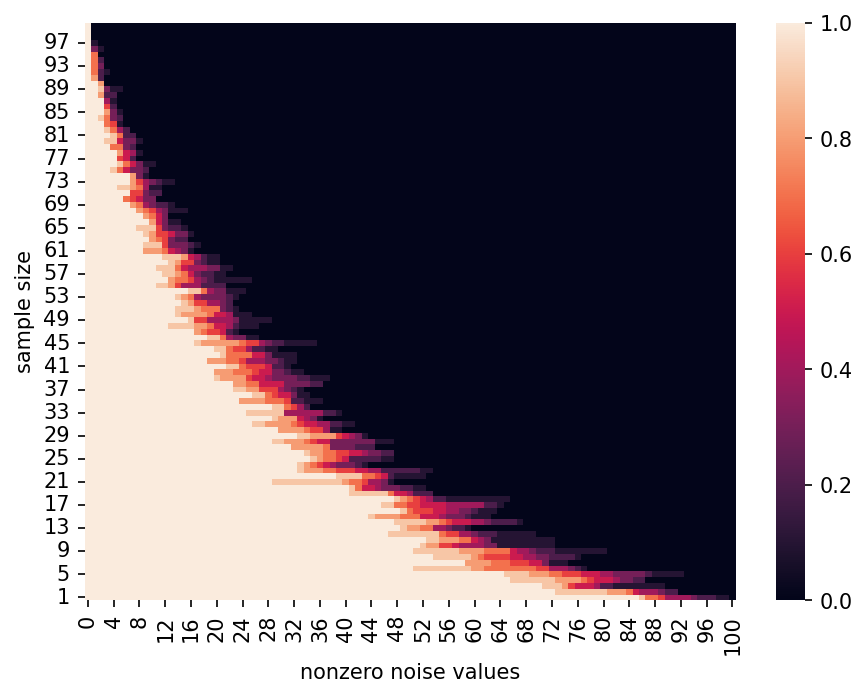

In [5]:
#%config InlineBackend.figure_formats = ['svg']
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


piv = pd.pivot_table(pd.DataFrame(data),
                     values='perfect recovery',
                     index='p',
                     columns='o')

ax = sns.heatmap(piv)
plt.ylabel('sample size')
plt.xlabel('nonzero noise values')
ax.invert_yaxis()

## Theoretical phase transition

As discussed in (Bellec and Koriyama 2023, sec. 2), the phase transition
can be predicted using simple computation based on the results of
Amelunxen et al. (2014). As in the
[Donoho-Tanner](donoho_tanner_phase_transition.qmd) phase transition,
the predicted theoretical curve that separates perfect recovery from
imperfect recovery involves the standard normal density and cumulative
distribution function.

In [6]:
from scipy.stats import norm
f = norm.pdf
Phi = norm.cdf

Assume that $p,n\to+\infty$ simultaneously with
$\lim \frac n p = \delta$. The simple computation in (Bellec and
Koriyama 2023, sec. 2) explains that perfect recovery occurs if $$
\frac{1}{\delta}
> 1 - \min_{t\in \mathbb R}
\mathbb E[\text{dist}(G, t \partial |\varepsilon_i|)^2]
$$ where $G\sim N(0,1)$ is independent of $\varepsilon_i$, and imperfect
recovery occurs if the strict inequality is reversed. Above,
$\partial |\epsilon_i| = \{\text{sign}(\varepsilon_i)\}$ if
$\epsilon_i\ne 0$ and $\partial |\epsilon_i = [-1,1]$ is the
subdifferential of the absolute value at $\varepsilon_i$.

Let $q= P(\varepsilon_i\ne 0)$ be the probability that a noise random
variable is nonzero. A parametric curve $t\mapsto (\delta(t),q(t))$ that
separates the $(\delta,q)$ plane in two regions (a perfect recovery
region and an imperfect recovery region), can be computed with $$
\delta(t) = \frac{1}{1- \mathbb E[\text{dist}(G, t \partial |\varepsilon_i|)^2]}
$$ and $q(t)$ solving the optimality condition for the minimization over
$t$ of the function $t\mapsto
\mathbb E[\text{dist}(G, t \partial |\varepsilon_i|)^2]
=
P(\varepsilon_i\ne 0)(1+t^2) +P(\varepsilon_i = 0)\mathbb E[(|G|-t)_+^2]$.
This gives the equation characterizing $q(t)$ on the phase transition,
namely, $$
0 = 
q(t) 2 t 
-(1-q(t)) 2 \mathbb E[(|G|-t)_+].
$$ and $\mathbb E[(|G|-t)_+]= 2 f(t) - 2 \Phi(-t)$ where $f$ is the
standard normal pdf and $\Phi(-t)=\int_t^\infty f(u)du$.

In [7]:
E_abs_G_minus_t_squared = lambda t: -2*t*f(t) + 2*(1+t**2)*Phi(-t)
q = lambda t: 2*(f(t) - t*Phi(-t)) / (t + 2*(f(t) - t*Phi(-t)))
p_by_n = lambda t: (1 - q(t)*(1+t**2) - (1-q(t))*E_abs_G_minus_t_squared(t))

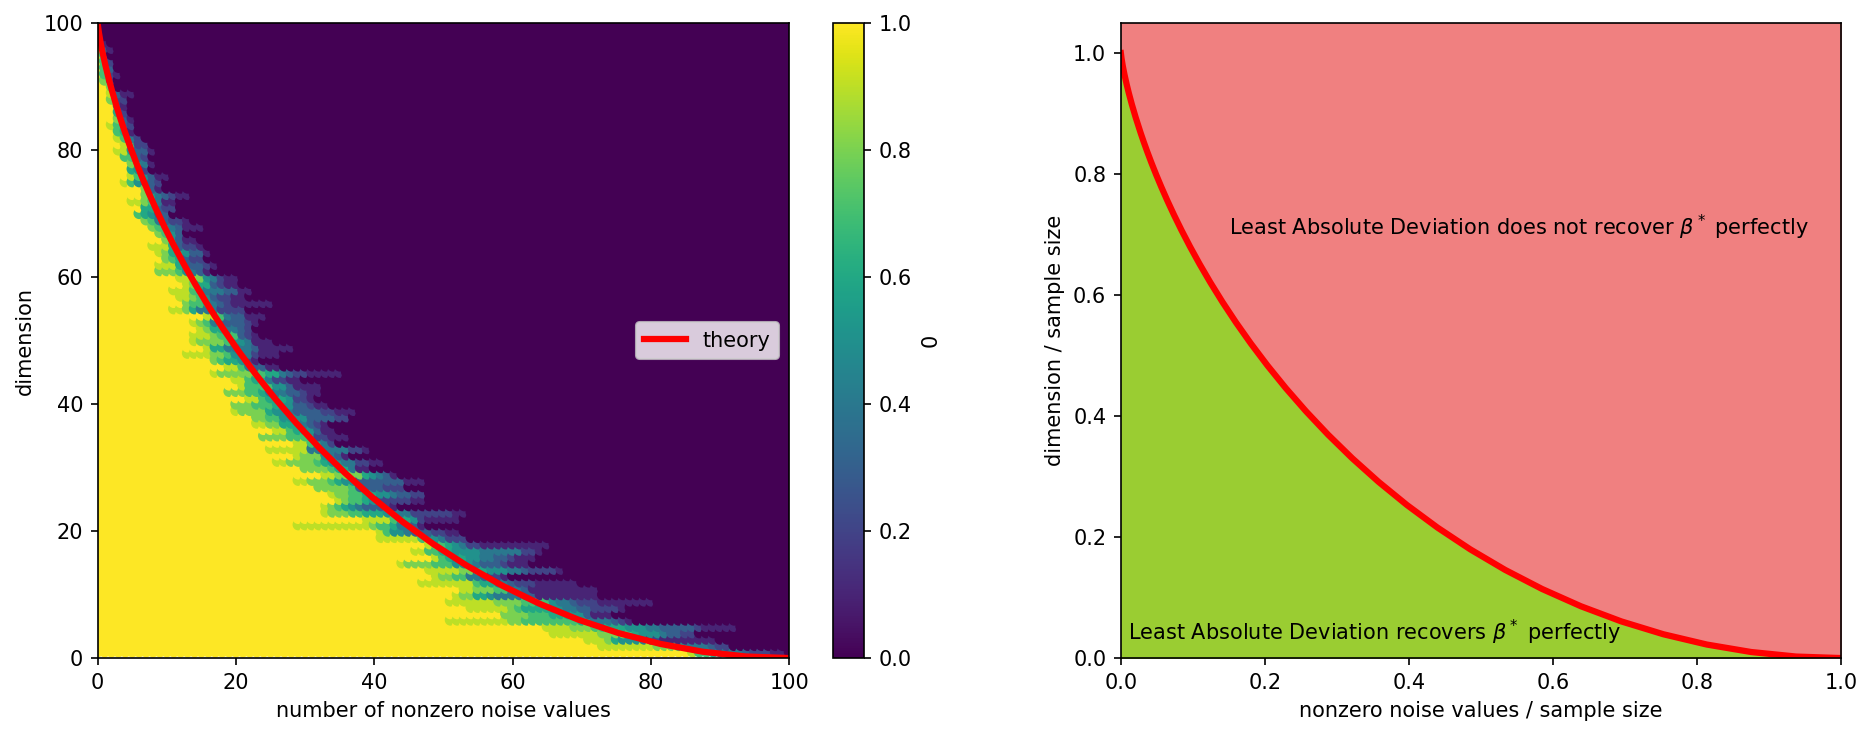

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150


fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
fig.set_size_inches(15, 5.5)

piv = pd.pivot_table(pd.DataFrame(data),
                     values='perfect recovery',
                     index='p',
                     columns='o')
t = np.linspace(0, 10, num=200)
piv.unstack().reset_index().plot(x='o', y='p', c=0, kind='scatter', ax=ax1)
grid = np.linspace(0.02, 10, num=500)
ax1.plot(n * q(t), n * p_by_n(t), color='red', label='theory', linewidth=3)
ax1.set_xlabel('number of nonzero noise values')
ax1.set_ylabel(r'dimension')
ax1.legend()

ax2.plot(q(t), p_by_n(t), color='red', label='theory', linewidth=3)
ax2.fill_between(q(t), p_by_n(t), color="yellowgreen")
maxy = ax2.get_ylim()[1]
ax2.fill_between(q(t), p_by_n(t), maxy, color="lightcoral")

ax2.text(0.01, 0.03 ,r"Least Absolute Deviation recovers $\beta^*$ perfectly")
ax2.text(0.15, 0.7 ,r"Least Absolute Deviation does not recover $\beta^*$ perfectly")

ax2.set_ylabel('dimension / sample size')
ax2.set_xlabel('nonzero noise values / sample size')
for ax in [ax1, ax2]:
    ax.margins(x=0, y=0)

Amelunxen, Dennis, Martin Lotz, Michael B McCoy, and Joel A Tropp. 2014.
“Living on the Edge: Phase Transitions in Convex Programs with Random
Data.” *Information and Inference*.

Bellec, Pierre C., and Takuya Koriyama. 2023. “Existence of Solutions to
the Nonlinear Equations Characterizing the Precise Error of
M-Estimators.” *arXiv Preprint*.